In [74]:
"""
train_gnn_only.py

Train a GNN autoencoder on spatial dataset A only to test whether
the GNN can learn meaningful latent embeddings for xenium_spatial.

Outputs:
 - gnn_only.pt         (model state_dict)
 - z_spatial_gnn.npy   (learned latent embeddings)
 - gnn_recon_loss.csv  (per-epoch recon loss)
 - embeddings_umap_gnn.png, embeddings_pca_gnn.png (visuals)
"""
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import scanpy as sc


In [75]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    # load
    A = sc.read_h5ad(spat_path)

    # Prefer obs column with broad labels (user should have created 'broad_cell_type' earlier)
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    if spat_label_col is None:
        print("Warning: spatial label column not found. Spatial labels will be None (can't compute test acc).")

    # Normalize total and log1p (inplace on copies)

    Ac = A.copy()
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # Convert to dense arrays (small 2k dataset assumed)
    X_spat = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X

    # labels
    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None

    # map labels to ints
    all_labels = np.unique(y_spat)
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    # spatial coords
    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"]

    return (label_to_id, X_spat.astype(np.float32), y_spat_id, Ac.obs_names.values, coords, all_labels)

In [76]:
## Loading the data
label_to_id, X_spat, y_spat, spat_ids, coords, all_labels = load_and_preprocess(
         spat_path="SmallData/xenium_spatial_common_genes.h5ad"
    )

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [77]:
# -------------------------
# === HYPERPARAMS ========
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

knn_k = 6
prune_pct = 0.20       # prune weakest 20% of weights
hidden_dim = 128
latent_dim = 32
epochs = 800
lr = 5e-4
patience = 50           # for early stopping on loss
batch_print = 50

In [78]:
# -------------------------
# === HELPERS ============
# -------------------------
def build_mutual_knn_weighted(coords, k=8, prune_pct=0.2, device=None):
    """
    coords: numpy (n,2) or torch (n,2)
    returns dense weighted adjacency (torch.tensor, float32) on device
    """
    if isinstance(coords, np.ndarray):
        coords_t = torch.from_numpy(coords).float()
    else:
        coords_t = coords.float()
    if device:
        coords_t = coords_t.to(device)
    n = coords_t.size(0)
    dists = torch.cdist(coords_t, coords_t)  # (n,n)
    dists.fill_diagonal_(float('inf'))
    knn_idx = torch.topk(dists, k=k, largest=False).indices  # (n,k)
    knn_lists = [set(knn_idx[i].cpu().tolist()) for i in range(n)]
    edges = set()
    for u in range(n):
        for v in knn_idx[u].cpu().tolist():
            if u in knn_lists[v]:
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))
    if len(edges) == 0:
        # fallback to symmetric knn
        for u in range(n):
            for v in knn_idx[u].cpu().tolist():
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))

    # estimate sigma as median distance to k-th neighbor
    kth = dists[torch.arange(n), knn_idx[:, -1]]
    sigma = float(kth.median().item())
    if sigma <= 0: sigma = 1.0

    A = torch.zeros((n,n), dtype=torch.float32, device=device)
    for (u,v) in edges:
        dist = torch.dist(coords_t[u], coords_t[v])
        w = float(torch.exp(- (dist**2) / (2.0 * sigma**2 + 1e-12)))
        A[u,v] = w; A[v,u] = w

    if prune_pct > 0.0:
        all_w = A[A>0].cpu().numpy()
        if len(all_w)>0:
            thresh = np.percentile(all_w, prune_pct*100)
            A[A < thresh] = 0.0
    return A

def normalize_adj_dense(A):
    """
    A: torch dense adjacency (n,n)
    returns normalized A_norm = D^-1/2 (A + I) D^-1/2
    """
    n = A.size(0)
    A_hat = A + torch.eye(n, device=A.device)
    deg = A_hat.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    return D_inv_sqrt @ A_hat @ D_inv_sqrt

In [79]:
# -------------------------
# === MODEL (GCN encoder) =
# -------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=True)
    def forward(self, X, A_norm):
        return F.relu(self.linear(A_norm @ X))

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, latent_dim)
    def forward(self, X, A_norm):
        h = self.gcn1(X, A_norm)
        z = self.gcn2(h, A_norm)  # (n, latent_dim)
        return z

In [80]:
# -------------------------
# === DGI discriminator ===
# -------------------------
class DGIDiscriminator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # simple bilinear scoring: x^T W s  (x: node embed, s: summary)
        self.weight = nn.Parameter(torch.randn(embed_dim, embed_dim) * 0.01)
    def forward(self, Z, summary):
        # Z: (n, d), summary: (d,) or (1,d)
        # produce score per node
        # score_i = z_i^T W s
        s = summary.view(-1)  # (d,)
        Ws = self.weight @ s   # (d,)
        scores = Z @ Ws       # (n,)
        return scores

In [81]:
# -------------------------
# === corruption ==========
# -------------------------
def corrupt_features(X):
    # row-wise shuffle features (simple and effective)
    idx = torch.randperm(X.size(0))
    return X[idx]

In [82]:
# -------------------------
# === training DGI ========
# -------------------------
def train_dgi(X_np, coords_np, labels_np=None):
    X = torch.from_numpy(X_np).to(device)
    coords = torch.from_numpy(coords_np).to(device)
    n = X.shape[0]
    # 1) build adjacency (mutual kNN weighted + prune)
    A = build_mutual_knn_weighted(coords_np, k=knn_k, prune_pct=prune_pct, device=device)
    A_norm = normalize_adj_dense(A)  # (n,n)
    print(f"Built adjacency: avg deg {(A>0).sum(dim=1).float().mean().item():.2f} (expected ~{knn_k*0.6:.1f} with mutual pruning)")

    # 2) model and discrim
    encoder = GCNEncoder(in_dim=X.shape[1], hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    disc = DGIDiscriminator(latent_dim).to(device)
    opt = torch.optim.Adam(list(encoder.parameters()) + list(disc.parameters()), lr=lr)

    # training loop
    best_loss = float('inf'); wait = 0
    for epoch in range(1, epochs+1):
        encoder.train(); disc.train()
        opt.zero_grad()

        Z = encoder(X, A_norm)            # positive embeddings (n,d)
        summary = torch.sigmoid(Z.mean(dim=0))  # global summary (d,)

        X_corr = corrupt_features(X)
        Z_corr = encoder(X_corr, A_norm)  # corrupted embeddings

        # discriminator scores
        pos_scores = disc(Z, summary)     # (n,)
        neg_scores = disc(Z_corr, summary) # (n,)

        # DGI loss: BCE on positive (1) and negative (0)
        labels_pos = torch.ones_like(pos_scores)
        labels_neg = torch.zeros_like(neg_scores)
        loss_pos = F.binary_cross_entropy_with_logits(pos_scores, labels_pos)
        loss_neg = F.binary_cross_entropy_with_logits(neg_scores, labels_neg)
        loss = loss_pos + loss_neg

        loss.backward()
        opt.step()

        if epoch % batch_print == 0 or epoch == 1:
            with torch.no_grad():
                # simple separation metrics
                pos_p = torch.sigmoid(pos_scores).mean().item()
                neg_p = torch.sigmoid(neg_scores).mean().item()
            print(f"Epoch {epoch:4d} | loss {loss.item():.4f} | pos_mean {pos_p:.4f} | neg_mean {neg_p:.4f}")

        # early stopping (simple)
        if loss.item() < best_loss - 1e-4:
            best_loss = loss.item(); wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch} (no improvement in {patience} iters).")
                break

    # final embeddings
    encoder.eval()
    with torch.no_grad():
        Z_final = encoder(X, A_norm).cpu().numpy()  # (n, latent_dim)

    # save
    np.save("Results_deep_model/xenium_dgi_embeddings.npy", Z_final)
    print("Saved embeddings to Results_deep_model/xenium_dgi_embeddings.npy")

    # === quick evaluations ===
    # adjacency reconstruction AUC / AP using dot product
    Zt = torch.from_numpy(Z_final)
    logits = (Zt @ Zt.t()).cpu().numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))
    A_np = (A.cpu().numpy() > 0).astype(int)
    n = A_np.shape[0]
    triu = np.triu_indices(n, k=1)
    try:
        auc = roc_auc_score(A_np[triu], probs[triu])
        ap = average_precision_score(A_np[triu], probs[triu])
    except Exception as e:
        auc, ap = None, None
    print("Adjacency reconstruction AUC:", auc, "AP:", ap)

    # silhouette (intrinsic clustering) via KMeans
    for k in [4,6,8,10]:
        try:
            km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(Z_final)
            sil = silhouette_score(Z_final, km.labels_)
            print(f"k={k} silhouette: {sil:.4f}")
        except Exception as e:
            print("KMeans failed for k", k, e)

    # UMAP projection
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2, random_state=seed)
    Z_umap = reducer.fit_transform(Z_final)
    plt.figure(figsize=(6,5))
    if 'labels_np' in locals() and labels_np is not None:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], c=labels_np, s=8)
        plt.title("DGI embeddings (UMAP) colored by GT labels (validation only)")
    else:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], s=8)
        plt.title("DGI embeddings (UMAP)")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.tight_layout(); plt.show()

    # also map clusters back to coordinates if labels provided
    if 'labels_np' in locals() and labels_np is not None:
        km = KMeans(n_clusters=max(2, len(np.unique(labels_np))), random_state=seed, n_init=10).fit(Z_final)
        plt.figure(figsize=(6,5))
        plt.scatter(coords_np[:,0], coords_np[:,1], c=km.labels_, s=6)
        plt.title("KMeans on DGI Z mapped to coords")
        plt.show()

    return Z_final

Built adjacency: avg deg 3.78 (expected ~3.6 with mutual pruning)
Epoch    1 | loss 1.3875 | pos_mean 0.5279 | neg_mean 0.5269
Epoch   50 | loss 0.8805 | pos_mean 0.7338 | neg_mean 0.3233
Epoch  100 | loss 0.4796 | pos_mean 0.8373 | neg_mean 0.1617
Epoch  150 | loss 0.2983 | pos_mean 0.8981 | neg_mean 0.1091
Epoch  200 | loss 0.2478 | pos_mean 0.8495 | neg_mean 0.0397
Epoch  250 | loss 0.1595 | pos_mean 0.9512 | neg_mean 0.0567
Epoch  300 | loss 0.1060 | pos_mean 0.9489 | neg_mean 0.0330
Epoch  350 | loss 0.0902 | pos_mean 0.9610 | neg_mean 0.0274
Epoch  400 | loss 0.1038 | pos_mean 0.9760 | neg_mean 0.0351
Epoch  450 | loss 0.0518 | pos_mean 0.9779 | neg_mean 0.0160
Epoch  500 | loss 0.0639 | pos_mean 0.9774 | neg_mean 0.0186
Early stopping at epoch 500 (no improvement in 50 iters).
Saved embeddings to Results_deep_model/xenium_dgi_embeddings.npy
Adjacency reconstruction AUC: 0.4973622076475163 AP: 0.0018814976697227722
k=4 silhouette: 0.3786
k=6 silhouette: 0.3238
k=8 silhouette: 0.2

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


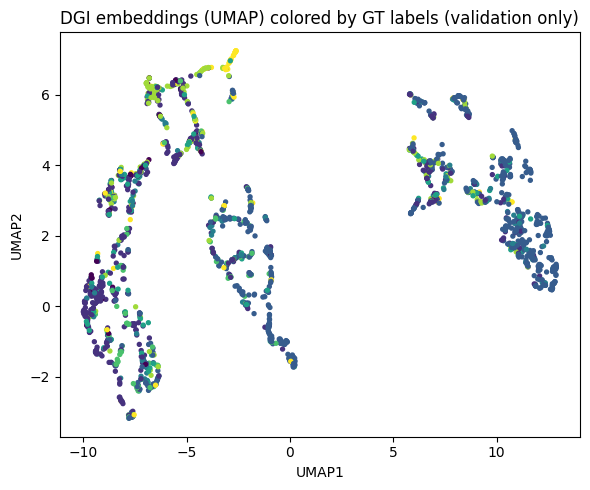

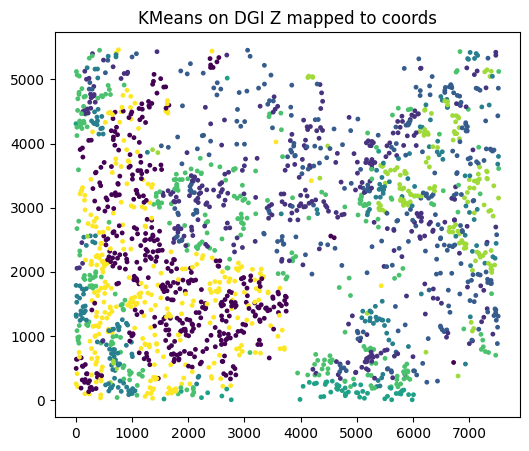

Done. Embeddings shape: (2000, 32)


In [83]:
Z = train_dgi(X_spat, coords, y_spat)
print("Done. Embeddings shape:", Z.shape)
